In [1]:
##Importing all needed libraries
try:
    # Summit-related imports
    import summit
    from summit import Runner
    from summit.benchmarks import SnarBenchmark
    from summit.domain import *
    from summit.utils.dataset import DataSet
    from summit.strategies import SOBO, MultitoSingleObjective, LHS

    # External libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # File and path handling
    import pathlib
    import os
    import logging
    import re

except ModuleNotFoundError as e:
    print(f"Error: {e}. Please install the required libraries before running the program.")

In [2]:
def create_domain(init_bounds_df):
    """
    Create a Summit domain based on the provided boundaries DataFrame.

    Parameters:
    - init_bounds_df (pd.DataFrame): DataFrame containing information about variable boundaries.

    Returns:
    - domain (Domain): The created Summit domain.
    - obj_df (pd.DataFrame): DataFrame for objective variables.
    - in_count (int): Count of input variables.
    - out_count (int): Count of output variables.
    """
    if not isinstance(init_bounds_df, pd.DataFrame) or init_bounds_df.empty:
        raise ValueError("Invalid input: init_bounds_df must be a non-empty DataFrame.")
        
    domain = Domain()
    obj_df = pd.DataFrame()
    obj_df = DataSet.from_df(obj_df)

    in_count = 0
    out_count = 0

    for idx, row in init_bounds_df.iterrows():
        name = row[0]
        description = row[5]
        data_type = row[1]

        if data_type == 'Categorical':
            levels = row[2].split(',')

            domain += CategoricalVariable(
                name = name,
                description = description,
                levels = levels
            )
            in_count += 1

        elif data_type == 'Continuous':
            bounds = [row[3], row[4]]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds
            )
            in_count += 1

        elif data_type == 'Objective':
            bounds = [row[3], row[4]]
            maximize = row[6]

            domain += ContinuousVariable(
                name = name,
                description = description,
                bounds = bounds,
                is_objective = True,
                maximize = maximize
            )
            out_count += 1

            obj_df[(name, "DATA")] = ""
        
    return domain, obj_df, in_count, out_count

In [3]:
def preprocess_data(data_df, init_bounds_df, out_count):
    """
    Preprocess the input data.

    Parameters:
    - data_df (pd.DataFrame): Input data DataFrame.
    - init_bounds_df (pd.DataFrame): DataFrame containing information about variable boundaries.
    - out_count (int): Count of output variables.

    Returns:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.
    - in_bounds_thresh_df (pd.DataFrame): Thresholds for initial boundary data.
    - INIT_BOUNDS_THRESH_FRAC (float): Fraction used for calculating bounds thresholds.
    - ach_func_bounds (list): Achievement function bounds.
    - ach_func_thresh (float): Threshold for the achievement function.
    """   
    # Constants
    DATA_COL_NAME = ('Achievement_Function','DATA')
    BOUNDS_COL_NAME = 'Threshold'
    INIT_BOUNDS_THRESH_FRAC = 0.25
    ACH_FUNC_THRESH_FRAC = 0.04
    
    # Achievement function bounds
    ach_func_bounds = [0,110] #Change this to automatic later on    
    
    # Calculate the achievement function
    data_df[DATA_COL_NAME] = (data_df.iloc[:, -1])
    
    # Copy the data DataFrame and sorts by the achievement function
    sorted_data_df = data_df.sort_values(
        by = DATA_COL_NAME,
        ascending = False
    ).copy()

    # Create a copy of the initial bounds DataFrame
    bounds_thresh_df = init_bounds_df.copy()
    
    # Calculate the threshold for the initial boundaries
    bounds_thresh_df[BOUNDS_COL_NAME] = (init_bounds_df.iloc[:, 4] - init_bounds_df.iloc[:, 3])*INIT_BOUNDS_THRESH_FRAC

    # Create a copy of the initial boundaries + threshold DataFrame and removes the output boundaries + threshold
    in_bounds_thresh_df = bounds_thresh_df.iloc[:-(out_count)].copy()

    # Calculate the achievement function threshold
    ach_func_thresh = (ach_func_bounds[1] - ach_func_bounds[0])*ACH_FUNC_THRESH_FRAC
    
    return sorted_data_df, in_bounds_thresh_df, INIT_BOUNDS_THRESH_FRAC, ach_func_bounds, ach_func_thresh

In [4]:
##All check functions
def check_af_converg(sorted_data_df):
    """
    Check the convergence of the achievement function for the top 3 rows.

    Parameters:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.

    Returns:
    - avg_diff_top_3 (float): Average absolute difference of the achievement function for the top 3 rows from their mean.
    """
    if len(sorted_data_df) < 3:
        raise ValueError("Insufficient data for convergence check. Need at least 3 rows.")

    top_3_af = sorted_data_df.iloc[:3, -1]
    avg_top_3 = top_3_af.mean()
    avg_diff_top_3 = np.abs(top_3_af - avg_top_3).mean()

    return avg_diff_top_3
    
def check_bounds(sorted_data_df, in_bounds_thresh_df, out_count, hard_boundaries):
    """
    Check if conditions are close to the upper or lower bounds.

    Parameters:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.
    - in_bounds_thresh_df (pd.DataFrame): Thresholds for initial boundary data.
    - out_count (int): Count of output variables.
    - hard_boundaries (dict): Hard boundaries for each variable.


    Returns:
    - close_to_max_bounds (list): Conditions close to the upper bounds.
    - close_to_min_bounds (list): Conditions close to the lower bounds.
    """
    if sorted_data_df.empty or in_bounds_thresh_df.empty:
        raise ValueError("Input DataFrames cannot be empty.")
    
    close_to_max_bounds = []
    close_to_min_bounds = []
    check_exp = sorted_data_df.iloc[0, 0:-(out_count + 2)].to_numpy()
    print(check_exp)
    for idx, row in in_bounds_thresh_df.iterrows():
        col_name = row['Condition']
        min_bounds = row['BoundaryMin']
        max_bounds = row['BoundaryMax']
        thresh = row['Threshold']
        val = check_exp[idx]    
        print(col_name)
        print(val)
        print(idx)
        
        if col_name not in ('Acrylate', 'Fluoro', 'Cyclo', 'Temperature'):
            continue
    
        if np.isfinite(val):
            if (val - min_bounds) <= thresh and min_bounds != hard_boundaries[col_name][0]:
                close_to_min_bounds.append(col_name)
            elif (max_bounds - val) <= thresh and max_bounds != hard_boundaries[col_name][1]:
                print(val)
                close_to_max_bounds.append(col_name)
    
    print(f"Close to max bounds: {close_to_max_bounds}")
    print(f"Close to min bounds: {close_to_min_bounds}")
    return close_to_max_bounds, close_to_min_bounds

def check_max_possibility(sorted_data_df, ach_func_thresh, ach_func_bounds):
    """
    Check if the achievement function is close to the upper bound.

    Parameters:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.
    - ach_func_thresh (float): Threshold for the achievement function.
    - ach_func_bounds (list): Achievement function bounds.

    Returns:
    - bool: True if near the upper bound, False otherwise.
    """
    if sorted_data_df.empty:
        raise ValueError("Input DataFrame 'sorted_data_df' cannot be empty.")
    
    if not ach_func_bounds or len(ach_func_bounds) != 2:
        raise ValueError("Invalid 'ach_func_bounds'. It should be a list of two values representing bounds.")
    
    if ach_func_thresh is None or not isinstance(ach_func_thresh, (int, float)):
        raise ValueError("Invalid 'ach_func_thresh'. It should be a numeric value.")
    
    upper_bound = ach_func_bounds[1]
    achievement_function_value = sorted_data_df.iloc[0, -1]

    if abs(achievement_function_value - upper_bound) < ach_func_thresh:
        print('Near the maximum possibility. Optimization has ended.')
        return #True

    return False

def check_goal(sorted_data_df, GOAL):
    """
    Check if the optimized result exceeds the specified goal.

    Parameters:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.
    - GOAL (float): Target goal.

    Returns:
    - bool: True if the goal is achieved, False otherwise.
    """
    if sorted_data_df.empty:
        raise ValueError("Input DataFrame 'sorted_data_df' cannot be empty.")

    if GOAL is None or not isinstance(GOAL, (int, float)):
        raise ValueError("Invalid 'GOAL'. It should be a numeric value.")

    # Check if the goal is achieved
    if sorted_data_df.iloc[0, -1] > GOAL:
        print('Optimized to the goal within given boundaries')
        return #True

    return False

def expand_bounds(sorted_data_df, in_bounds_thresh_df, init_bounds_df, EXPANSION_COEF, INIT_BOUNDS_THRESH_FRAC, out_count, hard_boundaries):
    """
    Expand boundaries based on parameters near the bounds.

    Parameters:
    - sorted_data_df (pd.DataFrame): Sorted data DataFrame.
    - in_bounds_thresh_df (pd.DataFrame): Thresholds for initial boundary data.
    - init_bounds_df (pd.DataFrame): Initial boundaries DataFrame.
    - EXPANSION_COEF (float): Expansion coefficient.
    - INIT_BOUNDS_THRESH_FRAC (float): Fraction used for calculating bounds thresholds.
    - out_count (int): Count of output variables.
    - hard_boundaries (dict): Hard boundaries for each variable.

    Returns:
    - bool: True if no parameters near the boundaries, False otherwise.
    """
    if sorted_data_df.empty or in_bounds_thresh_df.empty or init_bounds_df.empty:
        raise ValueError("Input DataFrames cannot be empty.")

    # Check if there are parameters near the bounds
    close_to_max_bounds, close_to_min_bounds = check_bounds(sorted_data_df, in_bounds_thresh_df, out_count, hard_boundaries)

    if not (close_to_max_bounds or close_to_min_bounds):
        print('No parameters near the boundaries')
        return True

    # Expand the boundaries based on proximity to the bounds
    for parameter in close_to_max_bounds:
        param_bounds_row = init_bounds_df.loc[init_bounds_df.iloc[:, 0] == parameter].copy()
        new_upper_bound = param_bounds_row.iloc[:, 4].item() + EXPANSION_COEF * (param_bounds_row.iloc[:, 4].item() - param_bounds_row.iloc[:, 3].item())
        if new_upper_bound > hard_boundaries[parameter][1]:
            new_upper_bound = hard_boundaries[parameter][1]
        logging.info(f"Expanded upper boundary for {parameter} to {new_upper_bound}")
        print(f"Expanded upper boundary for {parameter} to {new_upper_bound}")
        param_bounds_row[param_bounds_row.columns[4]] = new_upper_bound
        init_bounds_df.loc[init_bounds_df.iloc[:, 0] == parameter] = param_bounds_row
    
    for parameter in close_to_min_bounds:
        param_bounds_row = init_bounds_df.loc[init_bounds_df.iloc[:, 0] == parameter].copy()
        new_lower_bound = param_bounds_row.iloc[:, 3].item() - EXPANSION_COEF * (param_bounds_row.iloc[:, 4].item() - param_bounds_row.iloc[:, 3].item())
        if new_lower_bound < hard_boundaries[parameter][0]:
            new_lower_bound = hard_boundaries[parameter][0]
        logging.info(f"Expanded lower boundary for {parameter} to {new_lower_bound}")
        print(f"Expanded lower boundary for {parameter} to {new_lower_bound}")
        param_bounds_row[param_bounds_row.columns[3]] = new_lower_bound
        init_bounds_df.loc[init_bounds_df.iloc[:, 0] == parameter] = param_bounds_row

    return False

def find_last_iteration_with_log(log_file_path, log_message, EXPLORE_QUAN):
    """
    Find the last iteration number with a specific log message in the log file.

    Parameters:
    - log_file_path (str): Path to the log file.
    - log_message (str): Log message to search for.

    Returns:
    - int or None: Last iteration number with the log message, or None if not found.
    """
    # Updated regex to capture iteration number with decimals
    pattern = re.compile(r"Iteration ([\d.]+): Program started(.*?)Iteration \1: Program completed", re.DOTALL | re.IGNORECASE)

    try:
        with open(log_file_path, 'r') as log_file:
            log_content = log_file.read()
    except FileNotFoundError:
        logging.error(f"Error: Log file '{log_file_path}' not found. Please check the file path.")
        return False, None

    matches = re.findall(pattern, log_content)

    # Reverse the order to start from the last iteration
    matches.reverse()

    for iteration, logs in matches[:EXPLORE_QUAN]:  # Look in the last EXPLORE_QUAN iterations
        if log_message.lower() in logs.lower():  # Case-insensitive comparison
            return True, int(float(iteration))

    return False, None

def check_steps(init_bounds_df, GOAL, EXPANSION_COEF, data_df, out_count, EXPLORE_QUAN, hard_boundaries, verbose = True):
    """
    Check the optimization stage based on the current state of the dataset.

    Parameters:
    - init_bounds_df (pd.DataFrame): Initial boundaries DataFrame.
    - GOAL (float): Target goal.
    - EXPANSION_COEF (float): Expansion coefficient.
    - data_df (pd.DataFrame): Input data DataFrame.
    - out_count (int): Count of output variables.
    - EXPLORE_QUAN (int): Amount of iterations to explore
    - verbose (bool): Whether to print detailed information.

    Returns:
    - int: Check step (1, 2, 3, 4, or 5).
    """

    log_message = "Expansion of bounds dataframe"
    sorted_data_df, in_bounds_thresh_df, INIT_BOUNDS_THRESH_FRAC, ach_func_bounds, ach_func_thresh = preprocess_data(data_df, init_bounds_df, out_count)

    if check_max_possibility(sorted_data_df, ach_func_thresh, ach_func_bounds):
        if verbose:
            print('Near the maximum possibility. Optimization has ended.')
        return CHECK_STEP_OPTIMIZATION_ENDS, None

    log_found, last_iteration = find_last_iteration_with_log(log_file_path, log_message, EXPLORE_QUAN)

    if log_found:
        if verbose:
            print(f"Log message '{log_message}' found in iteration {last_iteration}.")
        return CHECK_STEP_LOG_MESSAGE_FOUND, last_iteration

    elif check_af_converg(sorted_data_df) < (ach_func_thresh):
        if check_goal(sorted_data_df, GOAL):
            if verbose:
                print('Optimized to the goal within given boundaries.')
            return CHECK_STEP_OPTIMIZATION_ENDS, None

        elif not expand_bounds(sorted_data_df, in_bounds_thresh_df, init_bounds_df, EXPANSION_COEF, INIT_BOUNDS_THRESH_FRAC, out_count, hard_boundaries):
            if verbose:
                print('The boundaries have been expanded. Please continue optimization.')
            return CHECK_STEP_EXPAND_BOUNDS, None

        else:
            if verbose:
                print('Optimized under the set goal. The reaction conditions have hit a plateau. Reevaluate the data.')
            return CHECK_STEP_CONTINUE_OPTIMIZATION, None #Temp Change

    else:
        if verbose:
            print('Continue with the optimization process.')
        return CHECK_STEP_CONTINUE_OPTIMIZATION, None

# Constants for check steps
CHECK_STEP_OPTIMIZATION_ENDS = 1
CHECK_STEP_CONTINUE_OPTIMIZATION = 2
CHECK_STEP_EXPAND_BOUNDS = 3
CHECK_STEP_HIT_PLATEAU = 4
CHECK_STEP_LOG_MESSAGE_FOUND = 5

In [5]:
def it_count(start_exp_num, fin_exp_num, suggest_amount, project_name):
    """
    Calculate iteration-related values based on the start and finish experiment numbers.

    Parameters:
    - start_exp_num (int): Starting experiment number.
    - fin_exp_num (int): Finish experiment number.
    - suggest_amount (int): Number of experiments to suggest.
    - PROJECT_NAME (str): Name of the project.

    Returns:
    - tuple: Tuple containing iteration number, model names, and iteration names.
    """

    if fin_exp_num < start_exp_num:
        raise ValueError("Finish experiment number should be greater than or equal to the start experiment number.")

    current_it = (fin_exp_num - start_exp_num) / suggest_amount
    next_it = current_it + 1
    prev_it = current_it - 1
    
    model_name = f"{project_name}_Model_It{current_it}.json"
    prev_model_name = f"{project_name}_Model_It{prev_it}.json"
    it_name = f"{project_name}_Exp_It{next_it}.csv"
    prev_it_name = f"{project_name}_Exp_It{current_it}.csv"

    return current_it, model_name, prev_model_name, it_name, prev_it_name


def create_initial_dataset(domain, DATA_NAME, START_EXP_NUM, obj_df, data_path, data_name, random_seed = 410): 
    """
    Create the initial dataset file and DataFrame.

    Parameters:
    - domain (dict): Domain for Latin Hypercube Sampling.
    - DATA_NAME (str): Name of the dataset file.
    - START_EXP_NUM (int): Starting experiment number.
    - RANDOM_SEED (int): Seed for random number generation.

    Returns:
    - pd.DataFrame: Initial experiment DataFrame.
    """
    categorical_method = "one-hot"
    
    initial_strategy = LHS(
        domain = domain, 
        random_state = np.random.RandomState(random_seed)
    ) 
    
    temp_start_exp_df = pd.DataFrame(initial_strategy.suggest_experiments(START_EXP_NUM)) 
    start_exp = pd.concat(
        [temp_start_exp_df, obj_df],
        axis = 1
    ) 
    
    # Check if the file already exists before overwriting
    file_path = data_path / data_name
    if file_path.exists():
        overwrite = input(f"The file '{data_name}' already exists. Do you want to overwrite it? (y/n): ")
        if overwrite.lower() != 'y':
            print("Operation canceled.")
            return start_exp
        
    start_exp.to_csv(
        data_path / DATA_NAME,
        index = True
    ) 
        
    print(f"The file '{DATA_NAME}' does not exist in the directory. A new file has been created, please update it with results") 
    return start_exp

#Function to do Summit optimization
def perform_summit_optimization(data_df, suggest_amount, expression, domain, project_name, model_path, it_path, data_path, DATA_NAME, start_exp_num, fin_exp_num, current_it, model_name, prev_model_name, it_name, prev_it_name,check_step):
    """
    Perform Summit optimization.

    Parameters:
    - data_df (pd.DataFrame): Data DataFrame.
    - suggest_amount (int): Number of experiments to suggest.
    - expression (str): Mathematical expression for optimization.
    - domain (dict): Domain for optimization.
    - project_name (str): Name of the project.
    - model_path (Path): Path to save/load optimization model.
    - it_path (Path): Path to save iteration data.
    - start_exp_num (int): Starting experiment number.
    - fin_exp_num (int): Finish experiment number.
    """

    if current_it == 0:

        #transform = MultitoSingleObjective(
            #domain = domain,
            #expression = expression,
            #maximize = True
        #)
        
        strategy = SOBO(
            domain = domain,
            #transform = transform
        )

        new_it = strategy.suggest_experiments(
            num_experiments = suggest_amount,
            prev_res = data_df
        )
        
        it_exp_df = pd.concat([data_df, new_it], axis = 0)
        it_exp_df.reset_index(drop = True, inplace = True)
        it_exp_df = it_exp_df.iloc[:, :-1]

        data_path = os.path.join(data_path, DATA_NAME)
        it_exp_df.to_csv(data_path, index=True)
        
        it_data_path = os.path.join(it_path, it_name)
        new_it.to_csv(it_data_path)
        
        model_data_path = os.path.join(model_path, model_name)
        strategy.save(model_data_path)
        
        print("Your first new experimental condition has been added to run. The model has been saved in the directory.")
        print(new_it)
        
    elif check_step == 3:
        #transform = MultitoSingleObjective(
            #domain = domain,
            #expression = expression,
            #maximize = True
        #)
        
        strategy = SOBO(
            domain = domain,
            #transform = transform
        )

        new_it = strategy.suggest_experiments(
            num_experiments = suggest_amount,
            prev_res = data_df
        )
        
        it_exp_df = pd.concat([data_df, new_it], axis = 0)
        it_exp_df.reset_index(drop = True, inplace = True)
        it_exp_df = it_exp_df.iloc[:, :-1]

        data_path = os.path.join(data_path, DATA_NAME)
        it_exp_df.to_csv(data_path, index=True)
        
        it_data_path = os.path.join(it_path, it_name)
        new_it.to_csv(it_data_path)
        
        model_data_path = os.path.join(model_path, model_name)
        strategy.save(model_data_path)
        
        print("A new experimental condition has been added to run. The model has been saved in the directory.")
        print(new_it)
    
    else:

        prev_it = data_df.iloc[-1:].copy()
        prev_it.to_csv(it_path / prev_it_name)
        
        strategy = SOBO.load(model_path / prev_model_name)
        
        new_it = strategy.suggest_experiments(
            num_experiments = suggest_amount,
            prev_res = prev_it
        )
        
        it_exp_df = pd.concat([data_df, new_it], axis = 0)
        it_exp_df.reset_index(drop = True, inplace = True)
        it_exp_df = it_exp_df.iloc[:, :-1]

        data_path = os.path.join(data_path, DATA_NAME)
        it_exp_df.to_csv(data_path, index=True)
        
        it_data_path = os.path.join(it_path, it_name)
        new_it.to_csv(it_data_path)
        
        model_data_path = os.path.join(model_path, model_name)
        strategy.save(model_data_path)
        
        print("A new experimental condition has been added to run. The model has been saved in the directory.")
        print(new_it)

def create_progress_graph(data_df, start_exp_num):
    """
    Create a progress graph to visualize the achievement function over experiment numbers.

    Parameters:
    - data_df (pd.DataFrame): Data DataFrame.
    - start_exp_num (int): Starting experiment number.
    """
    data_exp_num = data_df.index + 1
    data_ach_func = pd.to_numeric(data_df.iloc[:, -1], errors='coerce')  # Convert to numeric, handle errors as NaN

    # Split the data into two parts for better visualization
    plt.figure(figsize=(8, 6))
    plt.plot(
        data_exp_num[:start_exp_num],
        data_ach_func[:start_exp_num],
        marker='o',
        linestyle='-',
        color='grey',
        markersize=5,
        linewidth=1,
        label='Best Achievement (Initial)'
    )

    plt.plot(
        data_exp_num[start_exp_num:],
        data_ach_func[start_exp_num:],
        marker='o',
        linestyle='-',
        color='navy',
        markersize=5,
        linewidth=1,
        label='Best Achievement (After Optimization)'
    )
    
    plt.xlabel('Experiment Number')
    plt.ylabel('Achievement Function')
    plt.title('Experiment Results')
    plt.legend()  # Add legend to differentiate initial and optimized achievements
    plt.tight_layout()
    plt.show()

In [6]:
def main():
    # Constants
    file_path = os.path.join(data_path, DATA_NAME)
    START_EXP_NUM = 10
    SUGGEST_AMOUNT = 1
    EXPRESSION = "Output_Conc"
    GOAL = 130
    EXPANSION_COEF = 1
    EXPLORE_QUAN = 5
    check_distance = None
    
    hard_boundaries = {
    'Acrylate': (2.75, 5),
    'Fluoro': (2.75, 5),
    'Cyclo': (0.5, 1),
    'Temperature': (100, 200)
}
    
    domain, obj_df, in_count, out_count = create_domain(init_bounds_df)
    
    # Determines if there is an initial dataset that exists
    if not os.path.exists(file_path):
        logging.info(f"Creating initial dataset: {DATA_NAME}")
        create_initial_dataset(domain, DATA_NAME, START_EXP_NUM, obj_df, data_path, DATA_NAME,)
        return
    
    # Reads the initial dataset
    data_df = DataSet.read_csv(data_path / DATA_NAME) 
    logging.info(f"Reading dataset: {DATA_NAME}")
    
    # Determines that amount of total experiments equal amount of completed experiments
    exp_num = data_df.iloc[:, 0].count()
    fin_exp_num = data_df.iloc[:, -1].count()
    if exp_num - fin_exp_num != 0:
        logging.warning("Complete experiments and update .csv file.")
        return
    
    # Calculates the current iteration as well as all the names of models and iterations needed
    current_it, model_name, prev_model_name, it_name, prev_it_name = it_count(START_EXP_NUM, fin_exp_num, SUGGEST_AMOUNT, PROJECT_NAME)
    logging.info(f"Iteration {current_it}: Program started")
    
    # Check the status of the optimization progress
    check_step, check_value = check_steps(init_bounds_df, GOAL, EXPANSION_COEF, data_df, out_count, EXPLORE_QUAN, hard_boundaries)
    logging.info(f"This is check step: {check_step}")
    # Creates the progress graph
    create_progress_graph(data_df, START_EXP_NUM)

    # Reports what the status of the optimization progress is and halts the program or continues
    if check_step == 1 or check_step == 4:
        logging.warning("Optimization has been halted")
        return True

    if check_step == 3:
        logging.info("Expansion of bounds dataframe")
        init_bounds_df.to_csv(data_path / BOUNDS_NAME, index=False)
        domain, obj_df, in_count, out_count = create_domain(init_bounds_df)
        check_distance = 0
        
    if check_step == 5:
        logging.info("Exploration of expanded bounds")
        check_distance = current_it - check_value
        print(check_distance)
        
    # Performs the primiary optimization 
    perform_summit_optimization(data_df, SUGGEST_AMOUNT, EXPRESSION, domain, PROJECT_NAME, model_path, it_path, data_path, DATA_NAME, START_EXP_NUM, fin_exp_num, current_it, model_name, prev_model_name, it_name, prev_it_name,check_step)    
    # Log the iteration number at the end of the program
    logging.info(f"Iteration {current_it}: Program completed")
    return False

[3.9620726348844864 2.953701849507614 0.9840937574590424
 110.85163962970078]
Acrylate
3.9620726348844864
0
Fluoro
2.953701849507614
1
Cyclo
0.9840937574590424
2
Temperature
110.85163962970078
3
Close to max bounds: []
Close to min bounds: []
No parameters near the boundaries
Optimized under the set goal. The reaction conditions have hit a plateau. Reevaluate the data.


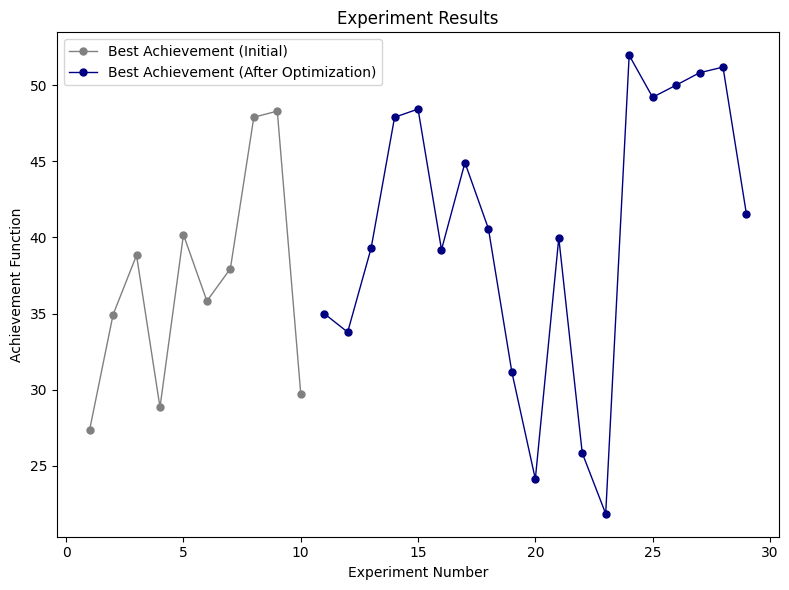

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


A new experimental condition has been added to run. The model has been saved in the directory.
NAME Acrylate    Fluoro Cyclo Temperature                 strategy
TYPE     DATA      DATA  DATA        DATA                 METADATA
0        2.75  4.271701   1.0  184.706468  Single-objective BayOpt


In [7]:
# Configurable parameters
base_path = pathlib.Path("D:\PyCharm_Projects\Digital_Twin_Optimization\Digital_Twin_Dataset")
PROJECT_NAME = "YumaDigi"
BOUNDS_NAME = f"{PROJECT_NAME}_Bounds.csv"
DATA_NAME = f"{PROJECT_NAME}_Data.csv"
LOG_NAME = f"{PROJECT_NAME}_Log.csv"

# Folder Name
DATA_DIR = "Data"
MODEL_DIR = "Models"
IT_DIR = "IterData"
LOG_DIR = "Logs"

# Function to create directory if it doesn't exist
def create_directory(base_path, directory):
    """Create a directory if it doesn't exist."""
    dir_path = base_path / directory
    if not dir_path.is_dir():
        dir_path.mkdir(parents=True)
        
# Create directories
for directory in [DATA_DIR, MODEL_DIR, IT_DIR, LOG_DIR]:
    create_directory(base_path, directory)

# Set data paths
data_path = base_path / DATA_DIR
model_path = base_path / MODEL_DIR
it_path = base_path / IT_DIR
log_path = base_path / LOG_DIR

# Configure logging
log_file_path = log_path / LOG_NAME
logging.basicConfig(
    filename = log_file_path,
    level = logging.INFO,
    format = "%(asctime)s - %(levelname)s - %(message)s",
)

# Load initial boundaries data
try:
    init_bounds_df = pd.read_csv(data_path / BOUNDS_NAME)
except FileNotFoundError:
    print(f"Error: File '{BOUNDS_NAME}' not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print(f"Error: File '{BOUNDS_NAME}' is empty or in an invalid format.")

if __name__ == "__main__":
    main()